# 2D Range-Bearing Landmark Resolution with Ceres

**High-level problem description:** A moving vehicle confined to the 2D plane is equipped with a range-bearing device that is giving noisy 2D range and bearing measurements pointing to a static landmark at regular intervals. The bearing error in the measurement can be thought of as a product of noise as well as a steady bias, whereas the range measurement is just noisy. The goal is to incrementally collapse uncertainty about where the static landmark is by moving the vehicle around and continually collecting noisy and biased measurements.

This article will lay out some approximating equations to solve this problem and provide a Python script to test out the solution together with some high-level observations.

## Prerequisite Readings

  * Math context: [Least Squares Optimization](https://andrewtorgesen.com/notes/Autonomy/Search_and_Optimization/Least-Squares_Optimization.html)
  * Solver context: [Ceres Solver Overview](https://andrewtorgesen.com/notes/Autonomy/Systems_Implementation/Optimization_Libraries/Ceres_Solver_Python_Tutorial_(Linux).html)

## Running the Python Demo

If you wish to run/modify the demo yourself (outside of this Nix-based scratchpad environment), you’ll need to install these Python packages:

  * numpy
    * For working with vectors and some basic linear algebra.
  * matplotlib
    * For visualization.
  * [ceres_python_bindings](https://github.com/Edwinem/ceres_python_bindings)$^*$
    * Third-party Python bindings for Ceres **< 2.1.0**. Provides the core library API discussed above.
  * [geometry](https://github.com/goromal/geometry)$^*$
    * Python bindings for a C$++$ templated library that implements the chart map operations for $SO(3)$ and $SE(3)$. With this library, the $\oplus$ and $\ominus$ operators are abstracted away into the normal plus and minus operators.
  * [pyceres_factors](https://github.com/goromal/pyceres_factors)$^*$
    * Python bindings for custom cost functions for Ceres that make use of the geometry package above.
   
## Problem Formulation

The three reference frames in the problem definition (see Fig. 1) are:

  * The static world frame $W$
  * The moving vehicle frame $B$
  * The sensor frame $S$, defined for convenience as having the x-axis aligned with the detected bearing measurement (*not* the actual static mounting orientation of the sensor w.r.t. the vehicle frame).

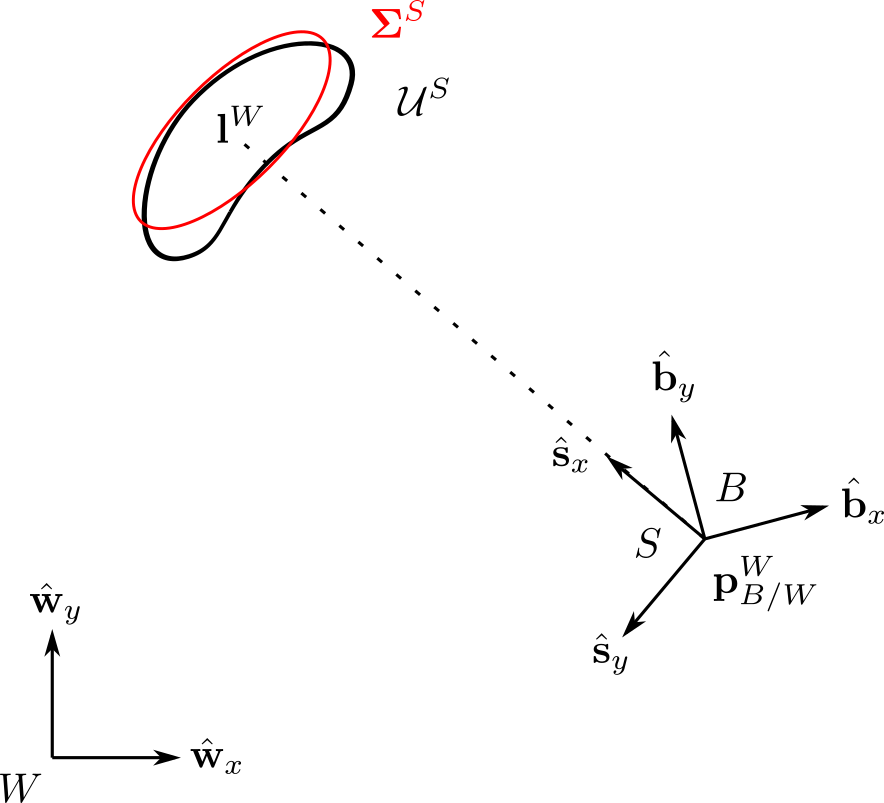

*Figure 1: Reference frames and uncertainty models for the range-bearing landmark localization problem. When expressed in the sensor ($S$) frame, the measurement covariance can be approximated as a diagonal matrix $\mathbf{\Sigma}^S$, though the true uncertainty distribution $\mathbf{\mathcal{U}}^S$ is a Gaussian over the $SE(2)$ manifold.*

FIXME explain $\mathbf{R}_S^W$

The uncertainty resulting from sensor noise is most appropriately derived in the $S$ frame (approximated by an ellipse) and subsequently re-expressed in the $W$ frame via a linear approximation:

$$\mathbf{\Sigma}^S\approx\begin{bmatrix}\sigma_d^2 & 0\\0 & \left(d\sigma_{\theta}\right)^2\end{bmatrix}.$$

$$\mathbf{\Sigma}^W\approx\mathbf{R}_S^W\mathbf{\Sigma}^S\left(\mathbf{R}_S^W\right)^\top.$$

This measurement covariance is associated with a world-frame range-bearing measurement, expressable as a 2D vector:

$$\mathbf{b}^W\triangleq\mathbf{R}_S^W\begin{bmatrix}d\\0\end{bmatrix}.$$

And the measurement of the static landmark location can be calculated at each time stamp as a function of the vehicle position in the world frame $\mathbf{p}^W_{B/W}$ and the range-bearing measurement $\mathbf{b}^W$ (which is altered by the unknown heading bias $\tilde{\mathbf{R}}$):

$$\mathbf{l}^W=\mathbf{p}^W_{B/W}+\tilde{\mathbf{R}}\mathbf{b}^W.$$

As illustrated in Fig. 2, though the vehicle may be moving across successive time stamps and collecting new range-bearing measurements, the *true* landmark location is known to be static, and that information/assumption can be exploited in the task of estimating its location along with the sensor heading bias term.

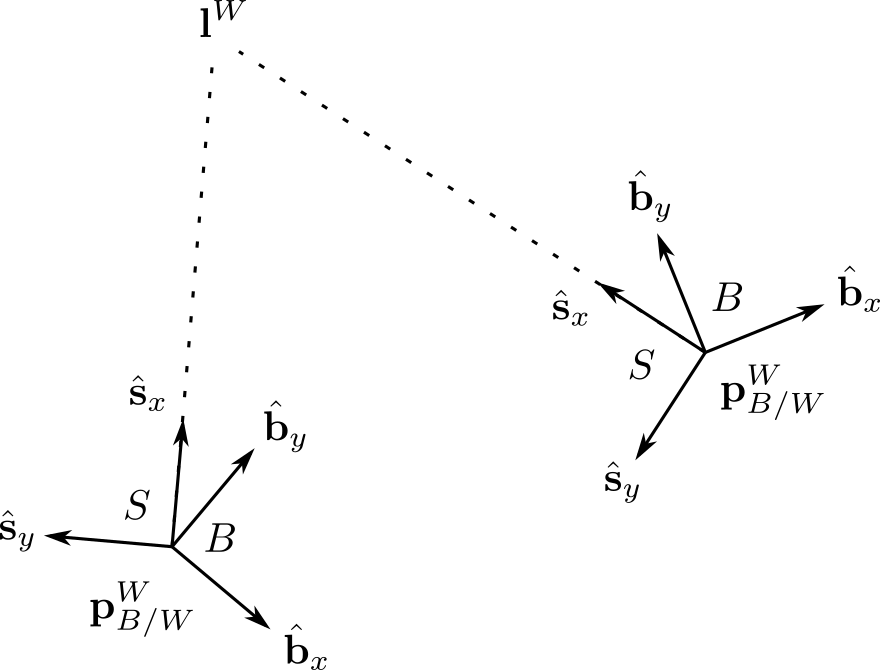

*Figure 2: Successive range-bearing measurements of a static landmark from a moving vehicle frame.*

The optimization will thus be defined as minimizing all error terms (or *residuals*) $\mathbf{r}_k$ across all time stamps which capture the difference between the current bearing measurement and the *implicit* bearing measurement derived from the current belief about the static landmark location. The residual term at each time stamp is scaled by the inverse square root of the measurement covariance, in keeping with the standard least-squares formulation:

$$\mathbf{r}_k=\left(\mathbf{\Sigma}_k^W\right)^{-1/2}\left(\mathbf{b}_k^W-\tilde{\mathbf{R}}^\top\left(\mathbf{l}^W-\mathbf{p}_{B/W,k}^W\right)\right).$$

The residual implementation in C++ (called *RangeBearing2DFactor*) can be found [in the ceres-factors source code](https://github.com/goromal/ceres-factors/blob/8bff0917d7a05d25f86b23ff097bfebf10a987f9/include/ceres-factors/Factors.h#L109) (which the Python package used in this demo wraps). At each time step $k$, a factor is constructed and added to the graph from

  * Range measurement $d_k$ with associated standard deviation $\sigma_d$
  * Heading measurement $\mathbf{R}_{S,k}^B$ with associated standard deviation $\sigma_{\theta}$ (assumed to be statically biased by an unknown mount calibration error $\tilde{\mathbf{R}}$)
  * The estimated vehicle position $\mathbf{p}_{B/W,k}^W$
  * The estimated vehicle orientation $\mathbf{R}_{B,k}^W$

from which the residual equation is computed using the preceding equations in this article.

## Solution

Below is the basic problem formulated as a Ceres Solver optimization. In this scenario, the sensor heading bias is zero and 100 measurements are taken as the vehicle moves with both translational and angular velocity.

In [22]:
import numpy as np
from geometry import SO2, SE2, SO3, SE3
import PyCeres as ceres
import PyCeresFactors as factors

# Measurement noise on range and heading
sigma_d = 0.02
sigma_theta = 0.02

# True landmark location
l = np.array([10.0, -5.0])

# Initial vehicle state and constant forward velocity with an angular component
x = SE2.identity()
v = np.array([1.0, 0.0, 0.5])

# Time step for simulation and measurement sample rate
dt = 0.1

# Initial (random) beliefs for heading bias and landmark location
R_err_hat = SO2.random().array()
l_hat = np.random.random(2)
print(f"Initial landmark location belief: {l_hat}")

# The only variables being optimized over are the heading bias and landmark location
problem = ceres.Problem()
problem.AddParameterBlock(R_err_hat, 2, factors.SO2Parameterization())
problem.AddParameterBlock(l_hat, 2)

# The vehicle will take 100 measurements as it moves across the 2D plane
for _ in range(100):
    # Construct synthetic measurement with (TODO) added noise
    d = np.linalg.norm(x.t() - l) + np.random.normal(0, sigma_d, 1).item()
    l_B = x.inverse() * l
    theta = SO2.fromTwoUnitVectors(np.array([1.,0.]), l_B / d).angle() + np.random.normal(0, sigma_theta, 1).item()
    p = x.t()
    phi = x.q().angle()
    problem.AddResidualBlock(factors.RangeBearing2DFactor(d, sigma_d, theta, sigma_theta, p, phi),
                             None, l_hat, R_err_hat)
    # Update vehicle state
    x += v * dt

# Solve the optimization problem
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# Assert that the estimated landmark location is essentially equal to the true one
print(f"Final landmark location belief: {l_hat}")
print(f"Actual landmark location:       {l}")
err = np.linalg.norm(l_hat - l)
print(f"Error:                          {err}")                         
assert err < 0.1

# Assert that the estimated heading bias is 0, since that's what it really was
est_heading_bias = abs(SO2.fromComplex(R_err_hat).angle())
print(f"Estimated heading bias:         {est_heading_bias}")
assert est_heading_bias < 1e-2

Initial landmark location belief: [0.20342673 0.83712216]
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.557467e+10    0.00e+00    6.47e+09   0.00e+00   0.00e+00  1.00e+04        0    2.29e-05    4.60e-05
   1  8.868288e+08    5.47e+10    8.95e+08   1.41e+01   9.84e-01  3.00e+04        1    2.81e-05    9.42e-05
   2  1.456474e+09   -5.70e+08    8.95e+08   9.36e+00  -6.43e-01  1.50e+04        1    1.10e-05    1.09e-04
   3  1.456330e+09   -5.70e+08    8.95e+08   9.36e+00  -6.43e-01  3.75e+03        1    6.91e-06    1.19e-04
   4  1.455458e+09   -5.69e+08    8.95e+08   9.35e+00  -6.42e-01  4.69e+02        1    5.96e-06    1.27e-04
   5  1.446496e+09   -5.60e+08    8.95e+08   9.28e+00  -6.32e-01  2.93e+01        1    5.96e-06    1.36e-04
   6  1.188375e+09   -3.02e+08    8.95e+08   8.24e+00  -3.43e-01  9.16e-01        1    5.96e-06    1.44e-04
   7  2.954094e+08    5.91e+08    3.29e+08   9.20e-01   1.05e+00  2.75e+00    